In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import torch
import pandas as pd

# from ResNet.ResNet_3D_3 import ResNet_3D as CNN, ResidualBlock
from ResNet.ResNet_2D_2 import ResNet_2D as CNN, ResidualBlock
from utils.datasets import *

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), torch.cuda.get_device_name()

(1, 'NVIDIA RTX A4000')

In [4]:
num_classes = 3
classes = ["background", "leaf", "diseased"]
eval_hist = [[[] for i in range(2 + num_classes)]for i in range(3)]
ssdir = "..//result//for paper//ResNet3D_3 augmented//"
oa = 18

with open(ssdir + "training.pckl", "rb") as f:
    eval_hist = pickle.load(f)
    
trained_epochs = len(eval_hist[0][0])

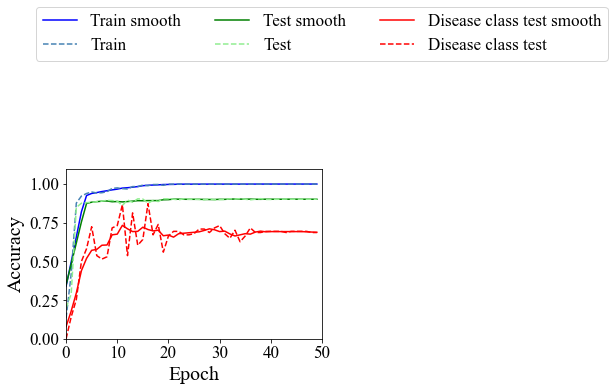

In [21]:
# Draw training graph

def smooth(y, box_pts=5):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

eval_hist_s = []

for data in eval_hist:
    data_c = copy.deepcopy(data)
    for i in range(len(data_c)):
        if len(data_c[i]) > 0: 
            data_c[i] = smooth(data_c[i])
        
    eval_hist_s.append(data_c)

epochs = [e for e in range(trained_epochs)]

# plt.figure(figsize=(5, 10))
# for i in range(num_classes):
#     ax = plt.subplot(311 + i)
#     ax.set_title(classes[i])
#     ax.plot(epochs, eval_hist_s[0][1 + i], 'blue', label='train smooth')
#     ax.plot(epochs, eval_hist[0][1 + i], 'steelblue', linestyle='dashed', label='train')
    
#     ax.plot(epochs, eval_hist_s[1][1 + i], 'red', label='test smooth')
#     ax.plot(epochs, eval_hist[1][1 + i], 'lightcoral', linestyle='dashed', label='test')
    
#     ax.legend(loc='lower right')

hfont = {'fontname':'Times New Roman',
         'size':20}

plt.figure(figsize=(5, 3.5))    
plt.rc('font', size=17, family='Times New Roman')
plt.yticks(fontname = "Times New Roman")
plt.xticks(fontname = "Times New Roman")
plt.plot(epochs, eval_hist_s[0][4], 'blue', label='Train smooth')
plt.plot(epochs, eval_hist[0][4], 'steelblue', linestyle='dashed', label='Train')
plt.plot(epochs, eval_hist_s[1][4], 'green', label='Test smooth')
plt.plot(epochs, eval_hist[1][4], 'lightgreen', linestyle='dashed', label='Test')
plt.plot(epochs, eval_hist_s[1][3], 'red', label='Disease class test smooth')
plt.plot(epochs, eval_hist[1][3], 'red', linestyle='dashed', label='Disease class test')
plt.ylim(0, 1.1)
plt.xlim(0, 50)
plt.xlabel('Epoch', **hfont)
plt.ylabel('Accuracy', **hfont)
plt.tight_layout()
plt.savefig('foo.png')
plt.legend(loc='upper center', bbox_to_anchor=(1, 2), ncol= 3)
plt.show()


In [5]:
val_patch = pd.read_csv(ssdir + "val.csv")
val_img = Img(_3d=False, img_df=val_patch)
test_loader = DataLoader(dataset=val_img, batch_size=128, shuffle=False)

In [6]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    )

In [7]:
def evaluateTorch(loader, model):
    actuals = []
    predictions = []
    evaluations = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, model_pred = scores.max(1)
            
            actuals.append(y)
            predictions.append(model_pred)
            
    actuals = torch.cat(actuals)
    predictions = torch.cat(predictions)
    
    evaluation_matrix = [[] for i in range(4)] # accuracy, recall, precission, f1
    for i in range(num_classes):
        ac = (actuals == i)
        pr = (predictions == i)
        na = (actuals != i)
        wp = (predictions != i)
        
        tp = (ac & pr).sum()
        fp = (na & pr).sum()
        tn = (na & wp).sum()
        fn = (ac & wp).sum()
        
        accuracy = tp / ac.sum()
        accuracy2 = (tp + tn) / (tp + fp + tn + fn)
        recall = tp / (tp + fn)
        precission = tp / (tp + fp)
        f1 = (2 * precission * recall) / (precission + recall)
        
        print(accuracy)
        
        evaluation_matrix[0].append(accuracy2)
        evaluation_matrix[1].append(recall)
        evaluation_matrix[2].append(precission)
        evaluation_matrix[3].append(f1)
        
    oa = (actuals == predictions).sum() / len(actuals)
    print(oa)
    
    for em in evaluation_matrix:
        e = [em_c.item() for em_c in em]
        print(sum(e) / len(e))
        evaluations.append(sum(e) / len(e))
 
    np_actuals = actuals.cpu().detach().numpy()
    np_predictions = predictions.cpu().detach().numpy()
    
    print("sk")
    print(accuracy_score(np_actuals, np_predictions))
    print(recall_score(np_actuals, np_predictions, average="macro"))
    print(precision_score(np_actuals, np_predictions, average="macro"))
    print(f1_score(np_actuals, np_predictions, average="macro"))
        
    return np_actuals, np_predictions

In [8]:
model = CNN(ResidualBlock).to(device)
model.load_state_dict(torch.load(ssdir + f"ResNet3D_노균병_OA{oa}_best.pt"))

<All keys matched successfully>

In [9]:
actual, prediction = evaluateTorch(test_loader, model)

tensor(0.8889, device='cuda:0')
tensor(0.9632, device='cuda:0')
tensor(0.4328, device='cuda:0')
tensor(0.8610, device='cuda:0')
0.907339076201121
0.7616580724716187
0.8732378681500753
0.7921615441640218
sk
0.8610086100861009
0.7616580754084724
0.8732378735041325
0.7921615341954725


In [10]:
from sklearn import metrics
from sklearn.metrics import roc_curve

def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Background", "Healthy", "Diseased"])
    cm_display.plot()
    plt.rc('font', size=15)
    plt.rcParams["font.family"] = "Times New Roman"
        
    if savefig:
        plt.savefig('confusion_matrix.png')
        
    plt.show()

    
def plotROCCurve(actual, prediction):
    fpr, tpr, threshold = roc_curve(actual, prediction)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

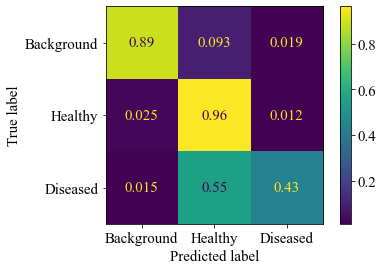

In [12]:
drawConfusionMatrix(actual, prediction, normalize=True, savefig=True)